In [2]:
#importando as bbts
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold, train_test_split
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import random
import itertools
from PIL import Image

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#caminho para o dataset
dataset_path = '/content/drive/MyDrive/trabalho_visao/BrainTumor_MRI_Scans'

#configurações principais
batch_size = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#transformações de imagem
transform = transforms.Compose([
    transforms.Resize((128, 128)),  #redimensiona as imagens para 128 por 128
    transforms.RandomHorizontalFlip(),  #aplica flip horizontal aleatório
    transforms.RandomRotation(10),  #aplica rotação aleatória de até 10 graus
    transforms.ToTensor(),  #converte para tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  #normaliza com os valores de ImageNet
])


#carregando o dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

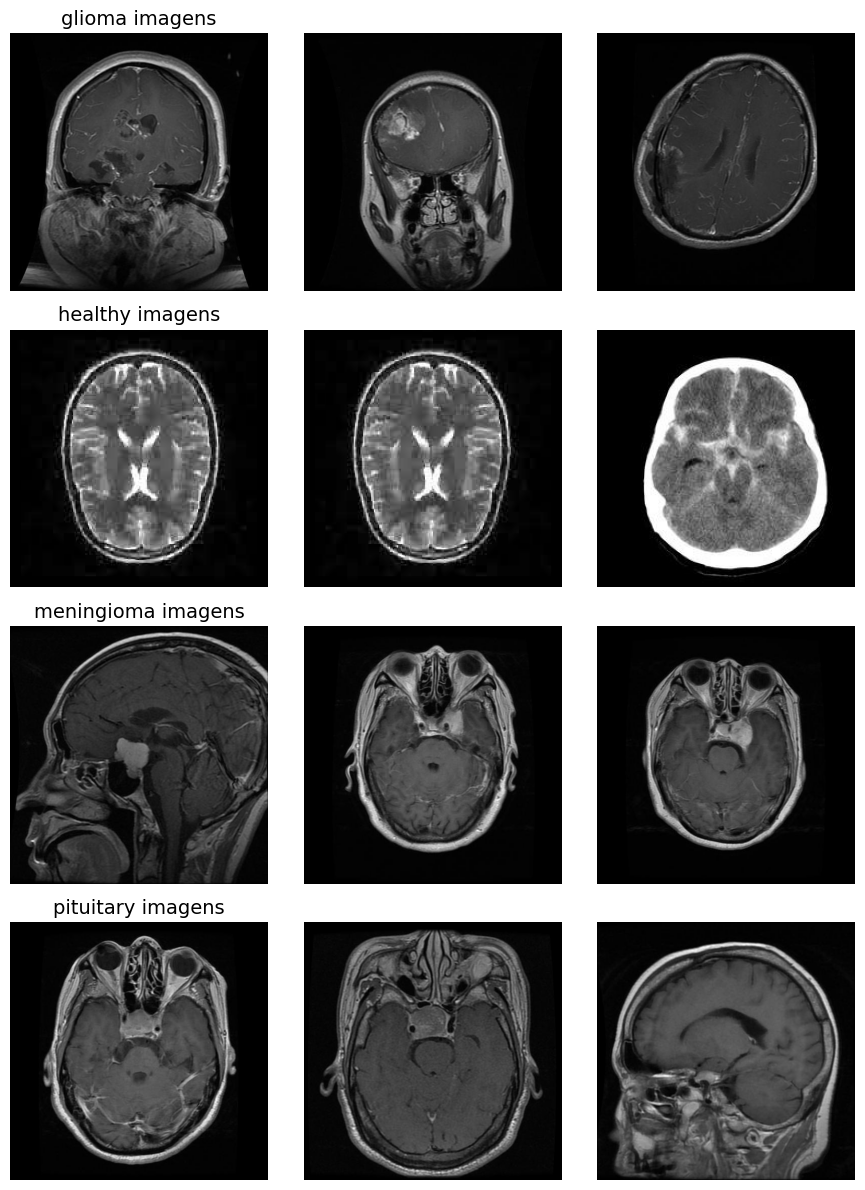

In [5]:
def show_class_samples(dataset, num_samples=3):
    #obter as classes do dataset
    classes = dataset.classes

    #configuração do gráfico
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(num_samples * 3, len(classes) * 3))

    for i, cls in enumerate(classes):
        #filtra as imagens da classe
        class_idx = dataset.class_to_idx[cls]
        #obtém caminhos das imagens e verifica se o arquivo existe
        class_images = [img for img, label in dataset.samples if label == class_idx and os.path.isfile(img)]

        # Verifica se há imagens suficientes para a classe
        if len(class_images) < num_samples:
            print(f"Erro: A classe '{cls}' tem apenas {len(class_images)} imagens disponíveis. Ajustando para exibir todas.")
            selected_images = class_images  #exibe todas as disponíveis
        else:
            selected_images = random.sample(class_images, num_samples)  #seleciona imagens aleatórias

        for j, img_path in enumerate(selected_images):
            #abre e exibe a imagem
            img = Image.open(img_path)  #img_path é o caminho da imagem
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(f"{cls} imagens", fontsize=14)

    plt.tight_layout()
    plt.show()

#exibindo amostras para as classes do dataset
show_class_samples(dataset)

In [ ]:
#dividindo o dataset em treino, validação e teste
train_val_dataset, test_dataset = train_test_split(dataset, test_size=0.15, random_state=42)
train_dataset, val_dataset = train_test_split(train_val_dataset, test_size=0.15, random_state=42)

#criando DataLoaders para cada conjunto
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
#função para treinar o modelo
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            #zera os gradientes
            optimizer.zero_grad()

            #forward e cálculo de perda
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            #backward e atualização dos pesos
            loss.backward()
            optimizer.step()

            #estatísticas
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100.0 * correct / total
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")
        torch.cuda.empty_cache()
        gc.collect()
    return model

In [ ]:
#função para avaliar o modelo
def evaluate_model(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

In [ ]:
def cross_validate_model(model, dataset, k_folds=5, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    kfold = KFold(n_splits=k_folds, shuffle=True)

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"Fold {fold + 1}/{k_folds}")

        #cria DataLoaders para o conjunto de treino e validação
        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetRandomSampler(val_idx)

        train_loader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size)
        val_loader = DataLoader(dataset, sampler=val_sampler, batch_size=batch_size)

        #cria uma nova cópia do modelo para cada fold
        model_fold = deepcopy(model).to(device)

        #configura critério e otimizador
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model_fold.parameters(), lr=0.001)

        #treina o modelo
        model_fold = train_model(model_fold, train_loader, criterion, optimizer, num_epochs)

        #avalia no conjunto de validação
        y_true, y_pred = evaluate_model(model_fold, val_loader, device)

        #matriz de confusão
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
        plt.title(f'Matriz de Confusão para Fold {fold + 1}')
        plt.xlabel('Predito')
        plt.ylabel('Real')
        plt.show()

        torch.cuda.empty_cache()
        gc.collect()

        #relatório de classificação
        print(f"\nRelatório de Classificação para Fold {fold + 1}:")
        print(classification_report(y_true, y_pred, target_names=dataset.classes))

In [ ]:
def train_model_with_hyperparameters(model, train_loader, criterion, optimizer, num_epochs, device):
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)  # Multiplicar pelo tamanho do batch
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)  # Dividir pelo total de amostras
        epoch_acc = 100.0 * correct / total
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")
    return model

In [ ]:
def grid_search(model, dataset, param_grid, k_folds=5, num_epochs=10):
    best_model = None
    best_acc = 0.0
    best_params = {}

    #gerar todas as combinações de hiperparâmetros
    param_combinations = list(itertools.product(*param_grid.values()))

    #loop por todas as combinações
    for params in param_combinations:
        print(f"Testando hiperparâmetros: {dict(zip(param_grid.keys(), params))}")

        #ajusta o modelo e os hiperparâmetros
        learning_rate = params[0]
        num_epochs = params[1]
        batch_size = params[2]

        #divide o dataset em treino e validação
        train_val_dataset, test_dataset = train_test_split(dataset, test_size=0.15, random_state=42)
        train_dataset, val_dataset = train_test_split(train_val_dataset, test_size=0.15, random_state=42)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        #recria o modelo e otimizador para cada combinação
        model_copy = deepcopy(model).to(device)  # Garante que o modelo seja transferido para o dispositivo
        optimizer = torch.optim.Adam(model_copy.parameters(), lr=learning_rate)
        criterion = torch.nn.CrossEntropyLoss()

        #treina o modelo com os hiperparâmetros atuais
        model_copy = train_model_with_hyperparameters(model_copy, train_loader, criterion, optimizer, num_epochs, device)

        #avalia o modelo no conjunto de validação
        y_true, y_pred = evaluate_model(model_copy, val_loader, device)
        accuracy = np.mean(y_true == y_pred)

        print(f"Precisão no conjunto de validação: {accuracy:.2f}")

        #se o modelo atual for o melhor, salvar
        if accuracy > best_acc:
            best_acc = accuracy
            best_model = model_copy
            best_params = dict(zip(param_grid.keys(), params))

    print(f"Melhores Hiperparâmetros: {best_params}")
    return best_model, best_params


In [ ]:
#treinando e avaliando os modelos com validação cruzada
models_to_train = {
    "VGG16": models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1),
    "ResNet18": models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1),
}

#ajusta a última camada do VGG16
num_classes = len(dataset.classes)
models_to_train["VGG16"].classifier[6] = nn.Linear(4096, num_classes)

#ajusta a última camada do ResNet18
models_to_train["ResNet18"].fc = nn.Linear(models_to_train["ResNet18"].fc.in_features, num_classes)

param_grid = {
    'learning_rate': [0.001, 0.0001],  #taxa de aprendizado
    'num_epochs': [5, 10],  #número de épocas
    'batch_size': [8, 16]  #tamanho do batch
}

#chama o Grid Search para encontrar os melhores hiperparâmetros
for model_name, model in models_to_train.items():
    print(f"\nTreinando Modelo: {model_name}")

    #realiza o grid search e obtém o melhor modelo e os melhores parâmetros
    best_model, best_params = grid_search(model, dataset, param_grid)

    #libera memória após grid search
    torch.cuda.empty_cache()
    gc.collect()

    #exibe os melhores hiperparâmetros encontrados
    print(f"Melhores Hiperparâmetros para o modelo {model_name}: {best_params}")

    #treinamento e validação cruzada com os melhores parâmetros
    print(f"\nTreinando com validação cruzada - Modelo: {model_name}")
    cross_validate_model(best_model, dataset, k_folds=5, num_epochs=best_params['num_epochs'])

    #libera memória antes de passar para o próximo modelo
    del best_model
    torch.cuda.empty_cache()
    gc.collect()